### Import modules

In [1]:
from numpy.linalg import inv
from scipy.interpolate import RegularGridInterpolator as rgi
import scipy.interpolate as interpolate
from itertools import permutations

import matplotlib as mpl
#matplotlib.use('Agg')
import pandas as pd
import scipy.stats
%matplotlib inline              
import emcee                    # for MCMC part
import numpy as np              # for generating random numbers, etc
import matplotlib.pyplot as plt # for plotting
import corner                   # for plotting the contours
import warnings                 # for ignoring the warnings (not recommended)
warnings.filterwarnings('ignore')

In [2]:
import matplotlib as mpl
#matplotlib.use('Agg')
def setup_color():
    from cycler import cycler
    colors = ['#000000', '#e41a1c', '#377eb8', '#ff7f00', '#4daf4a',
              '#f781bf', '#a65628', '#984ea3',
              '#999999']
    styles = ['-', '--', '-.', ':', '--', '-.', ':', '-', '--']
    plt.rc('axes', prop_cycle=(cycler('color', colors)+cycler('linestyle', styles)))
    
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['xtick.major.width'] = 2.0
    mpl.rcParams['xtick.major.pad'] = 5.0
    mpl.rcParams['xtick.major.size'] = 9.0
    mpl.rcParams['xtick.minor.width'] = 2.0
    mpl.rcParams['xtick.minor.pad'] = 5.0
    mpl.rcParams['xtick.minor.size'] = 6.0
    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['ytick.major.width'] = 2.0
    mpl.rcParams['ytick.major.pad'] = 5.0
    mpl.rcParams['ytick.major.size'] = 9.0
    mpl.rcParams['ytick.minor.width'] = 2.0
    mpl.rcParams['ytick.minor.pad'] = 5.0
    mpl.rcParams['ytick.minor.size'] = 6.0
    mpl.rcParams['ytick.right'] = True
    mpl.rcParams['xtick.top'] = True
    mpl.rcParams['font.family'] = "Nimbus Sans Narrow" #'DejaVu Sans'
    mpl.rcParams['font.size'] = 18
    mpl.rcParams['axes.linewidth'] = 2       
    mpl.rcParams['legend.frameon'] = False
    mpl.rcParams['legend.fontsize'] = 13
    mpl.rcParams['figure.facecolor'] = 'w' 

In [3]:
setup_color()

### Load data

In [3]:
Bk=np.load("bkr_z0.50.npz") #bk is actually the bao ratios
k=Bk['k']
br=Bk['bkr']
bkrm=Bk['bkrm'].T[0]

In [4]:
bkrm

array([1.23460239, 1.04134798, 0.99714893, ..., 1.00063003, 1.00521369,
       1.01014833])

### Interpolation

In [5]:
k1=np.unique(k[:,0])
k2=np.unique(k[:,1])
k3=np.unique(k[:,2])

kk1,kk2,kk3=np.meshgrid(k1,k2,k3)

tup_Bk=[tuple(i) for i in k[:,0:3]]

output = np.empty(shape=(len(k1),len(k2),len(k3)))

for i in range(len(k1)):
    for j in range(len(k2)):
        for l in range(len(k3)):
            kkk=[i for i in permutations((kk1[i,j,l],kk2[i,j,l],kk3[i,j,l]))]
            if any(set(kkk).intersection(set(tup_Bk))):
                ind=tup_Bk.index(list(set(kkk).intersection(set(tup_Bk)))[0])
                #print((kk1[i,j,k],kk2[i,j,k],kk3[i,j,k]))
                #print(Bk5[ind,0:3])
                output[i,j,l]=bkrm[ind]
            else:
                output[i,j,l]=np.nan 

In [6]:
output_fillnan=output.flatten()
output_fillnan=pd.DataFrame(output_fillnan)
output_fillnan=output_fillnan.interpolate(method='linear', limit_direction='forward', axis=0)

output_fillnan=np.array(output_fillnan)
output_fillnan=np.reshape(output_fillnan,(len(k1),len(k2),len(k3)))

In [7]:
ff=rgi((k1,k2,k3),output_fillnan,method="linear",bounds_error=False,fill_value=0)

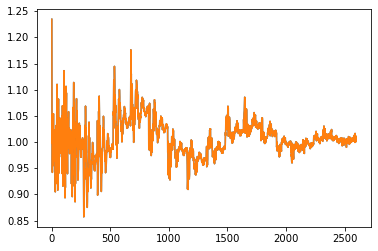

In [8]:
plt.plot(ff((k)))
plt.plot(bkrm)

### Masking and Covariance matrix

In [9]:
kmin=0.1
kmax=0.2
is_good = np.ones(k.shape[0], '?')
for i in range(3):is_good &= (k[:, i] > kmin) & (k[:, i] < kmax)
kg = k[is_good, :]
bg = bkrm[is_good]
nbins, nmocks = br[is_good, :].shape
#hartlapf = (nmocks-1.0)/(nmocks-nbins-2.0)
hartlapf=1
print(f'kmax={kmax}, kmin={kmin}, nbins={nbins}, nmocks={nmocks}')
cov = np.cov(br[is_good, :], rowvar=True)*hartlapf / nmocks
icov = inv(cov)

kmax=0.2, kmin=0.1, nbins=220, nmocks=922


### Model Fitting

In [10]:
model = lambda x,a,bi,b1,c: ff(a*x)+bi*(1/x[:,0]+1/x[:,1]+1/x[:,2])+b1*(x[:,0]+x[:,1]+x[:,2])+c

Define log-likehood function. This estimates how good the model fits to data for a set of parameters

In [11]:
def ln_like(params, x, y, cov):
    model_y = model(x, *params)
    diff = y - model_y
    #chisq = res.dot(icov.dot(res))
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

Define prior function. This sets the bounds for the parameters

In [ ]:
def ln_prior(params):
    if np.all(params[1:] >= -0.5) and np.all(params[1:] <= 0.5) and 0.9<=params[0]<=1.1:
        return 0.0
    return -np.inf

Define log probabilty that combines the above steps 

In [ ]:
def ln_prob(params, x, y, cov):
    lp = ln_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_like(params, x, y, cov)

### Find starting params ,i.e., maximum likelihood parameters estimate

In [15]:
from scipy.optimize import minimize

# Choose the "true" parameters.
a_true = 1
bi_true = 0
b1_true = 0

np.random.seed(42)
nll = lambda *args: -ln_like(*args)
initial = np.array([a_true, bi_true,b1_true.0]) + 0.05 * np.random.randn(3)
soln = minimize(nll, initial, args=(kg, bg, cov))
m_ml, b_ml, log_f_ml = soln.x
print(soln.x)

print("Maximum likelihood estimates:")
print("a = {0:.3f}".format(m_ml))
print("bi = {0:.3f}".format(b_ml))
print("b1 = {0:.3f}".format(log_f_ml))

SyntaxError: invalid syntax (2471564229.py, line 10)

### Run MCMC

Run 50 MCMC walkers in 3 dimensional parameter space (remember our goal is to constraint 3 parameters). The initial position of random walkers are sampled from a uniform distribution ie. U(--1.5,1.5). Each walker takes 200 steps

In [ ]:
ndim = 4
nwalkers = 100

np.random.seed(42)
guess=[1,0,0,0]
starting_params = guess + 1e-2 * np.random.randn(nwalkers,ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prob,
                                args=[kg, bg, cov])

num_steps = 5000
pos, prob, state = sampler.run_mcmc(starting_params, num_steps,progress=True)

100%|██████████| 100/100 [00:03<00:00, 32.59it/s]


Visualization of walkers paths along each axis

Text(0.5, 0, 'steps')

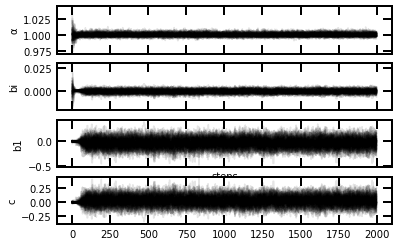

In [257]:
fig, ax = plt.subplots(ndim, sharex=True)
ylabels = ['\u03B1','bi','b1',"c"]
for i in range(ndim):
    ax[i].set_ylabel(ylabels[i])
    ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.1);
ax[2].set_xlabel('steps')

It is clear that we need to dump first 50-100 steps (as known as burn-in steps)

In [258]:
samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(samples.shape)

(12600, 4)


In [162]:
samples = sampler.chain[:, :, :].reshape((-1, ndim))

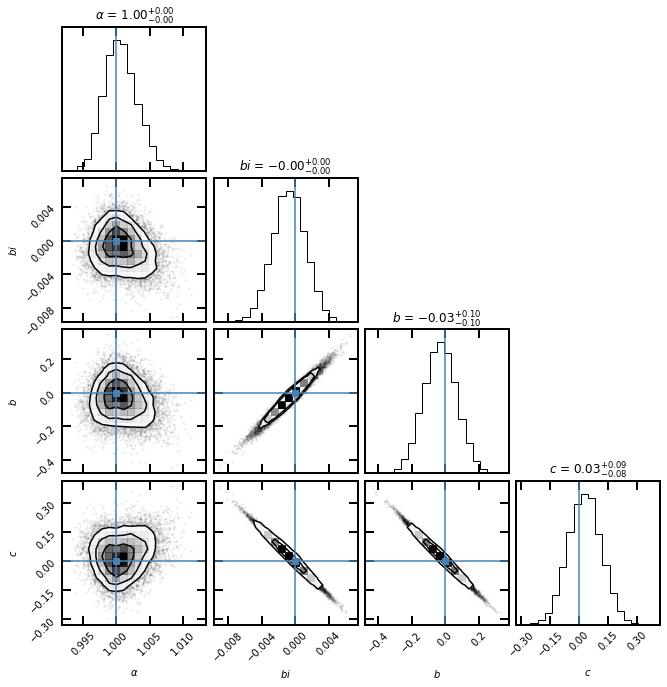

In [259]:
fig = corner.corner(samples, labels=["$\u03B1$", "$bi$", '$b$','$c$'],
                      truths=[1, 0, 0, 0],show_titles=True)

In [240]:
fig.savefig('bk_mcmc.png')


In [29]:
%%time
for _ in range(1000):
    arr = model(k,1,0,0,0)

CPU times: user 1.04 s, sys: 7.22 ms, total: 1.04 s
Wall time: 1.04 s


In [32]:
arr.shape

(2600,)